In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm
import re
import copy
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score
from yellowbrick.cluster import KElbowVisualizer
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

In [2]:
ls drive/MyDrive/ВКР_Рекомендательная_система/

'!03&04_17_VSE.csv'   выкупленные.xlsx               города_для_регионов.xlsx
 витрина.xlsx        'выкупленные с классами.xlsx'   расставленные.xlsx


## витрина с нормировкой

In [3]:
df_all = pd.read_excel('drive/MyDrive/ВКР_Рекомендательная_система/расставленные.xlsx',index_col=0)

In [4]:
df_buy = pd.read_excel('drive/MyDrive/ВКР_Рекомендательная_система/выкупленные.xlsx',index_col=0)

In [5]:
df_buy.reset_index(drop=True, inplace=True)

In [ ]:
df_all.МетодДоставки.unique()

array(['Курьерская', 'Магазины', 'Pick point', 'DPD',
       'Транспортная компания', 'Самовывоз', 'Почта России'], dtype=object)

In [ ]:
df_buy.МетодДоставки.unique()

array(['Магазины'], dtype=object)

In [6]:
df_finall = df_all[df_all.Телефон_new.isin(df_buy.Телефон_new.unique())]
df_finall.reset_index(drop=True, inplace=True)

In [7]:
df_finall.Телефон_new.nunique()

57749

In [8]:
def summary(x):
    result = {
        'КоличествоЧеков': x[(x.НовыйСтатус=='Доставлен')&(x.Статус=='Доставлен')&(x.Отменено=='Нет')&(x.КоличествоПроданоКлиенту>0)]['НомерЗаказаНаСайте'].nunique(), #чеки с хоть одним выкупленным товаром
        'СреднийЧек': x[(x.НовыйСтатус=='Доставлен')&(x.Статус=='Доставлен')&(x.Отменено=='Нет')&(x.КоличествоПроданоКлиенту>0)]['СуммаСтроки'].sum() / x[(x.НовыйСтатус=='Доставлен')&(x.Статус=='Доставлен')&(x.Отменено=='Нет')&(x.КоличествоПроданоКлиенту>0)]['НомерЗаказаНаСайте'].nunique(), #средняя сумма по чекам с выкупленными товарами
        'СреднееЧислоТоваровЧека': x[(x.НовыйСтатус=='Доставлен')&(x.Статус=='Доставлен')&(x.Отменено=='Нет')&(x.КоличествоПроданоКлиенту>0)]['Количество'].sum() / x[(x.НовыйСтатус=='Доставлен')&(x.Статус=='Доставлен')&(x.Отменено=='Нет')&(x.КоличествоПроданоКлиенту>0)]['НомерЗаказаНаСайте'].nunique(), #среднее количество товаров в чеках с выкупленными товарами
        'Выручка': x[(x.НовыйСтатус=='Доставлен')&(x.Статус=='Доставлен')&(x.Отменено=='Нет')&(x.КоличествоПроданоКлиенту>0)]['СуммаСтроки'].sum(), #выручка по выкупленным товарам
        'КоличествоТоваров': x['Количество'].sum(), #количество товаров, которые собирались купить
        'СредняяМаржа': x[(x.НовыйСтатус=='Доставлен')&(x.Статус=='Доставлен')&(x.Отменено=='Нет')&(x.КоличествоПроданоКлиенту>0)]['Маржа'].mean(), #средняя маржа по выкупленным товарам
        'ДоляВыкупленных': x[(x.НовыйСтатус=='Доставлен')&(x.Статус=='Доставлен')&(x.Отменено=='Нет')&(x.КоличествоПроданоКлиенту>0)]['КоличествоПроданоКлиенту'].sum() / x['Количество'].sum(), #доля выкупленных товаров
        'ПроцентОтмен': x[(~(x.НовыйСтатус=='Доставлен'))|(~(x.Статус=='Доставлен'))|(~(x.Отменено=='Нет'))|(~(x.КоличествоПроданоКлиенту>0))]['Отменено'].count() / x['Отменено'].count(), #доля отмененных товаров НАДО УТОЧНИТЬ МБ ИСПРАВИТЬ НА УНИКАЛЬНЫЕ ЗАКАЗЫ
        'КоличествоЧековВсе': x['НомерЗаказаНаСайте'].nunique(),
        'СреднийЧекВсе': x['СуммаСтроки'].sum() / x['НомерЗаказаНаСайте'].nunique(),
        'СреднееЧислоТоваровЧекаВсе': x['Количество'].sum() / x['НомерЗаказаНаСайте'].nunique(),
        'ВыручкаВся': x['СуммаСтроки'].sum(),
        'СредняяМаржаВся': x['Маржа'].mean(),
    }
    out = pd.Series(result).round(3)
    return out.fillna(0)

In [ ]:
df_type = pd.crosstab(df_finall['Телефон_new'],
            df_finall['Тип'],
            values=df_finall['КоличествоПроданоКлиенту'],
            aggfunc='sum',
            normalize='index').round(3)

In [ ]:
df_group2 = pd.crosstab(df_finall['Телефон_new'],
            df_finall['Группа2'],
            values=df_finall['КоличествоПроданоКлиенту'],
            aggfunc='sum',
            normalize='index').round(3)

In [ ]:
df1 = pd.merge(df_type, df_group2, on ='Телефон_new')

In [ ]:
df_geo = pd.crosstab(df_finall['Телефон_new'],
            df_finall['Гео'],
            normalize='index').round(3)

In [ ]:
df2 = pd.merge(df1, df_geo, on ='Телефон_new')

In [ ]:
df_region = pd.crosstab(df_finall['Телефон_new'],
            df_finall['Регион'],
            normalize='index').round(3)

In [ ]:
df3 = pd.merge(df2, df_region, on ='Телефон_new')

In [ ]:
df_sum = df_finall.groupby('Телефон_new').apply(summary)

In [ ]:
df_finall_mart = pd.merge(df_sum, df3, on ='Телефон_new')

In [ ]:
df_finall_mart.replace(np.inf, 0, inplace=True)

In [ ]:
df_finall_mart

,КоличествоЧеков,СреднийЧек,СреднееЧислоТоваровЧека,Выручка,КоличествоТоваров,СредняяМаржа,ДоляВыкупленных,ПроцентОтмен,КоличествоЧековВсе,СреднийЧекВсе,...,МО,Москва,Регионы,CENTRAL,FAR EAST,NORTH,PRIVOLZIE,SIBERIA,SOUTHERN,URAL
Телефон_new,,,,,,,,,,,,,,,,,,,,,
0,517.0,2940.555,3.634,1520267.01,7150.0,214.408,0.263,0.756,2256.0,3376.090,...,0.142,0.451,0.407,0.673,0.002,0.093,0.101,0.026,0.067,0.039
32555749-545749525150 .,1.0,1039.000,5.000,1039.00,5.0,34.932,1.000,0.000,1.0,1039.000,...,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
55494851-56495152535476,1.0,1630.000,1.000,1630.00,1.0,376.020,1.000,0.000,1.0,1630.000,...,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000
55574848-48485149515175,1.0,62740.000,2.000,62740.00,4.0,13606.500,0.500,0.500,3.0,26803.333,...,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
55574848-48485149515377,1.0,4460.000,1.000,4460.00,1.0,1467.000,1.000,0.500,1.0,4460.000,...,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56575053-49545153535383,1.0,1435.000,1.000,1435.00,1.0,165.270,1.000,0.000,1.0,1435.000,...,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
56575454-48485156545486,1.0,1620.000,1.000,1620.00,1.0,957.890,1.000,0.000,1.0,1620.000,...,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
56575655-52525750505484,1.0,1125.000,1.000,1125.00,1.0,95.000,1.000,0.000,1.0,1125.000,...,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000


In [ ]:
# df_finall_mart.to_excel("витрина.xlsx") 

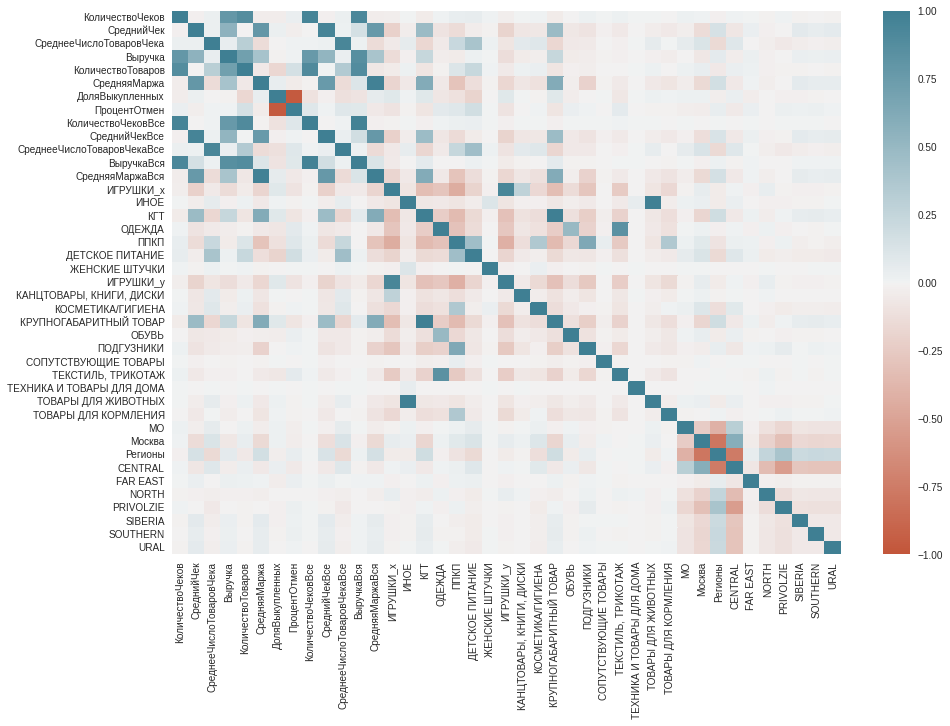

In [ ]:
fig = plt.figure(figsize=(15,10))
sns.heatmap(df_finall_mart.corr(),vmin=-1,vmax=1,cmap=sns.diverging_palette(20,220,as_cmap=True))

In [ ]:
corr=df_finall_mart.corr()
corr.style.background_gradient(cmap='coolwarm')

,КоличествоЧеков,СреднийЧек,СреднееЧислоТоваровЧека,Выручка,КоличествоТоваров,СредняяМаржа,ДоляВыкупленных,ПроцентОтмен,КоличествоЧековВсе,СреднийЧекВсе,СреднееЧислоТоваровЧекаВсе,ВыручкаВся,СредняяМаржаВся,ИГРУШКИ_x,ИНОЕ,КГТ,ОДЕЖДА,ППКП,ДЕТСКОЕ ПИТАНИЕ,ЖЕНСКИЕ ШТУЧКИ,ИГРУШКИ_y,"КАНЦТОВАРЫ, КНИГИ, ДИСКИ",КОСМЕТИКА/ГИГИЕНА,КРУПНОГАБАРИТНЫЙ ТОВАР,ОБУВЬ,ПОДГУЗНИКИ,СОПУТСТВУЮЩИЕ ТОВАРЫ,"ТЕКСТИЛЬ, ТРИКОТАЖ",ТЕХНИКА И ТОВАРЫ ДЛЯ ДОМА,ТОВАРЫ ДЛЯ ЖИВОТНЫХ,ТОВАРЫ ДЛЯ КОРМЛЕНИЯ,МО,Москва,Регионы,CENTRAL,FAR EAST,NORTH,PRIVOLZIE,SIBERIA,SOUTHERN,URAL
КоличествоЧеков,1.000000,-0.017272,0.027493,0.788422,0.877726,-0.034439,-0.035594,0.034983,0.957458,-0.015811,0.028040,0.927405,-0.033819,-0.024003,0.005794,-0.040064,0.014848,0.045122,0.051892,0.009421,-0.026767,0.005241,0.015606,-0.040064,-0.004279,0.015895,0.000740,0.019768,0.000994,0.004665,-0.000274,0.018704,0.009060,-0.020364,0.010398,0.002700,-0.015031,0.009478,-0.008641,-0.003652,-0.009075
СреднийЧек,-0.017272,1.000000,0.024506,0.552903,-0.001743,0.783892,0.025306,-0.027479,-0.007459,0.955524,0.018619,0.160374,0.769311,-0.207385,-0.038068,0.481719,-0.088422,-0.137384,-0.037932,-0.008708,-0.190149,-0.074760,-0.067095,0.481719,-0.067344,-0.088112,-0.016136,-0.060121,-0.002166,-0.037231,-0.060234,-0.028666,-0.135655,0.145400,-0.076109,0.034807,-0.019361,-0.006199,0.071095,0.054103,0.062783
СреднееЧислоТоваровЧека,0.027493,0.024506,1.000000,0.042154,0.307115,-0.139380,-0.001043,0.008680,0.010672,0.023008,0.942701,0.016309,-0.137716,-0.053207,0.057060,-0.165392,-0.049017,0.220857,0.404780,0.021819,-0.081456,0.076233,0.099673,-0.165392,-0.060258,-0.047075,-0.003914,-0.019108,0.000535,0.054910,0.001283,0.055241,0.122601,-0.150019,0.100413,-0.002904,-0.030024,-0.057016,-0.037726,-0.018621,-0.030865
Выручка,0.788422,0.552903,0.042154,1.000000,0.715308,0.407255,-0.012026,0.010727,0.770746,0.529917,0.038611,0.861464,0.400242,-0.135685,-0.018662,0.240924,-0.038303,-0.042247,0.018569,0.001892,-0.126892,-0.041662,-0.025971,0.240924,-0.040404,-0.038110,-0.008419,-0.019074,-0.001008,-0.018989,-0.031885,-0.002010,-0.068546,0.065556,-0.033001,0.023441,-0.020201,-0.005735,0.035621,0.031045,0.031352
КоличествоТоваров,0.877726,-0.001743,0.307115,0.715308,1.000000,-0.062310,-0.167136,0.159353,0.902940,0.006000,0.349888,0.885183,-0.065031,-0.042392,0.021080,-0.078949,-0.012612,0.115070,0.227312,0.012063,-0.051607,0.021921,0.035334,-0.078949,-0.022661,-0.023891,-0.000604,-0.000476,0.001755,0.019724,-0.006004,0.022492,0.045796,-0.057216,0.034077,0.017168,-0.016320,-0.015361,-0.012615,-0.007132,-0.013933
СредняяМаржа,-0.034439,0.783892,-0.139380,0.407255,-0.062310,1.000000,0.040104,-0.040268,-0.015413,0.758049,-0.139889,0.115340,0.978938,-0.185947,-0.062173,0.611628,-0.057300,-0.290532,-0.120672,-0.014156,-0.167715,-0.075148,-0.107882,0.611628,-0.027024,-0.202259,-0.015223,-0.049268,-0.003299,-0.060826,-0.085380,-0.037994,-0.151948,0.166597,-0.059837,0.014104,-0.028021,-0.001780,0.063039,0.047572,0.050477
ДоляВыкупленных,-0.035594,0.025306,-0.001043,-0.012026,-0.167136,0.040104,1.000000,-0.961966,-0.096179,-0.019558,-0.110809,-0.090863,0.055093,0.086021,0.015131,0.087503,-0.077482,-0.102784,-0.190772,-0.007228,0.088786,0.002058,-0.013037,0.087503,-0.038590,-0.000080,0.002590,-0.065353,0.000678,0.016082,0.008942,0.017436,0.020616,-0.030395,0.037209,-0.034104,-0.002531,-0.018796,-0.016380,-0.014822,-0.006375
ПроцентОтмен,0.034983,-0.027479,0.008680,0.010727,0.159353,-0.040268,-0.961966,1.000000,0.098037,0.007878,0.097529,0.089061,-0.061243,-0.086998,-0.013614,-0.083009,0.075012,0.101382,0.178360,0.007126,-0.090340,-0.000487,0.012451,-0.083009,0.037043,0.007930,-0.003336,0.063466,-0.000854,-0.014529,-0.009283,-0.023935,-0.033713,0.046801,-0.048848,0.031877,-0.005787,0.030825,0.018276,0.023661,0.010930
КоличествоЧековВсе,0.957458,-0.007459,0.010672,0.770746,0.902940,-0.015413,-0.096179,0.098037,1.000000,-0.006769,0.013919,0.974937,-0.016170,-0.014829,0.000632,-0.020197,0.009460,0.024449,0.036286,0.004600,-0.01590

## витрина без нормировки

In [9]:
df_type_without_norm = pd.crosstab(df_finall['Телефон_new'],
            df_finall['Тип'],
            values=df_finall['КоличествоПроданоКлиенту'],
            aggfunc='sum')

In [10]:
df_group2_without_norm = pd.crosstab(df_finall['Телефон_new'],
            df_finall['Группа2'],
            values=df_finall['КоличествоПроданоКлиенту'],
            aggfunc='sum')

In [11]:
df1_without_norm = pd.merge(df_type_without_norm, df_group2_without_norm, on ='Телефон_new')

In [12]:
df_geo_without_norm = pd.crosstab(df_finall['Телефон_new'],
            df_finall['Гео'])

In [13]:
df2_without_norm = pd.merge(df1_without_norm, df_geo_without_norm, on ='Телефон_new')

In [14]:
df_region_without_norm = pd.crosstab(df_finall['Телефон_new'],
            df_finall['Регион'])

In [15]:
df3_without_norm = pd.merge(df2_without_norm, df_region_without_norm, on ='Телефон_new')

In [16]:
df_sum_without_norm = df_finall.groupby('Телефон_new').apply(summary)

In [17]:
df_finall_mart_without_norm = pd.merge(df_sum_without_norm, df3_without_norm, on ='Телефон_new')

In [18]:
df_finall_mart_without_norm.replace(np.inf, 0, inplace=True)

In [19]:
df_finall_mart_without_norm

,КоличествоЧеков,СреднийЧек,СреднееЧислоТоваровЧека,Выручка,КоличествоТоваров,СредняяМаржа,ДоляВыкупленных,ПроцентОтмен,КоличествоЧековВсе,СреднийЧекВсе,...,МО,Москва,Регионы,CENTRAL,FAR EAST,NORTH,PRIVOLZIE,SIBERIA,SOUTHERN,URAL
Телефон_new,,,,,,,,,,,,,,,,,,,,,
0,517.0,2940.555,3.634,1520267.01,7150.0,214.408,0.263,0.756,2256.0,3376.090,...,822,2613,2356,3889,14,536,584,150,386,223
32555749-545749525150 .,1.0,1039.000,5.000,1039.00,5.0,34.932,1.000,0.000,1.0,1039.000,...,0,5,0,5,0,0,0,0,0,0
55494851-56495152535476,1.0,1630.000,1.000,1630.00,1.0,376.020,1.000,0.000,1.0,1630.000,...,0,0,1,0,0,0,1,0,0,0
55574848-48485149515175,1.0,62740.000,2.000,62740.00,4.0,13606.500,0.500,0.500,3.0,26803.333,...,0,0,4,0,0,0,0,0,4,0
55574848-48485149515377,1.0,4460.000,1.000,4460.00,1.0,1467.000,1.000,0.500,1.0,4460.000,...,0,0,2,0,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56575053-49545153535383,1.0,1435.000,1.000,1435.00,1.0,165.270,1.000,0.000,1.0,1435.000,...,0,1,0,1,0,0,0,0,0,0
56575454-48485156545486,1.0,1620.000,1.000,1620.00,1.0,957.890,1.000,0.000,1.0,1620.000,...,0,1,0,1,0,0,0,0,0,0
56575655-52525750505484,1.0,1125.000,1.000,1125.00,1.0,95.000,1.000,0.000,1.0,1125.000,...,0,0,1,0,0,0,1,0,0,0


In [20]:
df_finall_mart_without_norm.to_excel("витрина без нормировки.xlsx") 